<a href="https://colab.research.google.com/github/Ehsan-Roohi/DSMC_Python/blob/main/DSMC_Cavity_Kn%3D0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parsing file: ./CavityKn0.1.dat...
Successfully parsed 2500 points and 11 variables.

Data preprocessing for single Kn complete.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ position_input (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fourier_features_2              │ (None, 256)            │             0 │
│ (FourierFeatures)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,689 (780.04 KB)

 Trainable params: 199,689 (780.04 KB)

 Non-trainable params: 0 (0.00 B)


Training the final high-capacity model for Kn = 0.1
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - loss: 0.0539 - val_loss: 0.0130
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0121 - val_loss: 0.0065
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0071 - val_loss: 0.0042
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 12/

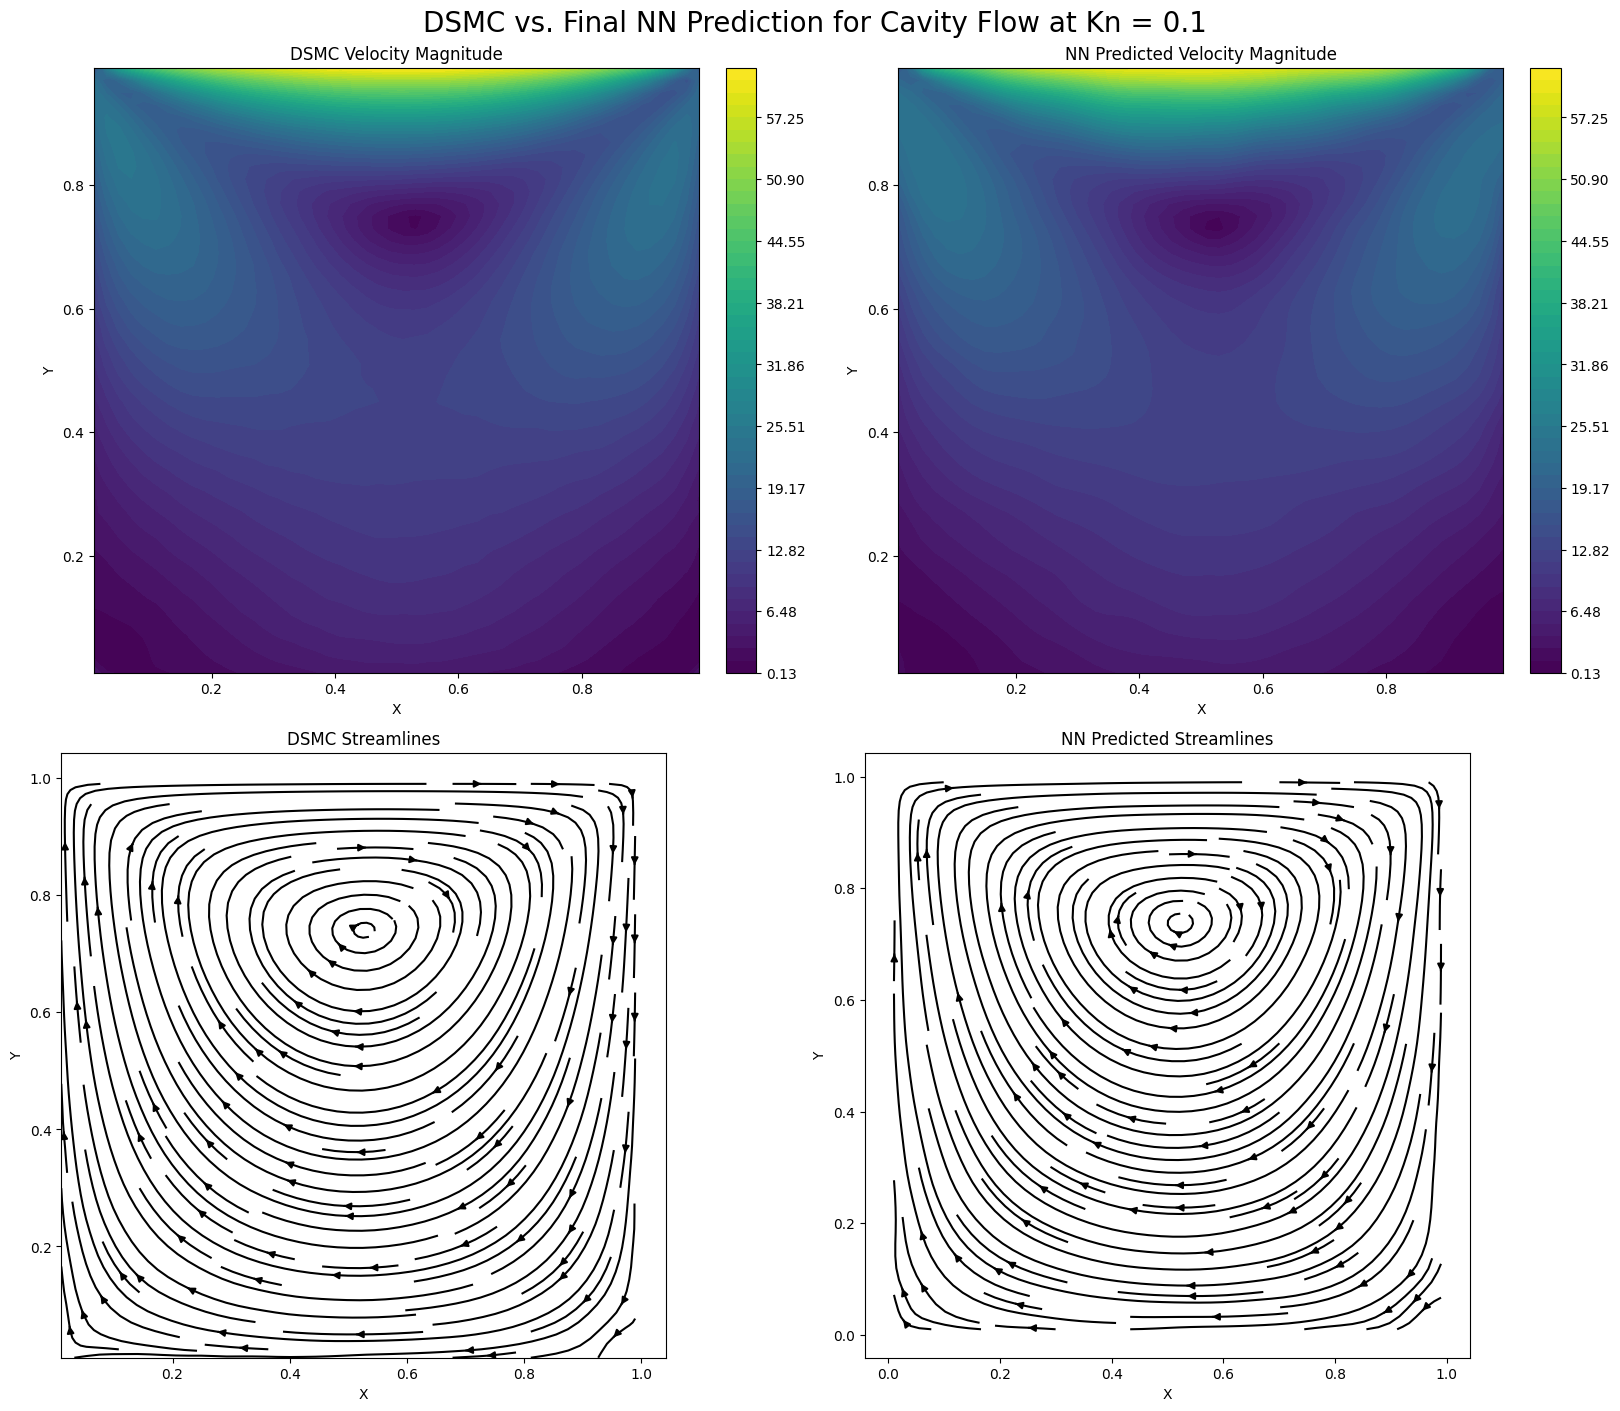

In [3]:
# --- گام ۰: وارد کردن کتابخانه‌ها و تنظیمات اولیه ---
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import griddata
import random

# برای اطمینان از نتایج تکرارپذیر
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# --- گام ۱: تابع پارسر نهایی برای خواندن فایل‌های Tecplot ---
def parse_tecplot_block_ascii(file_path):
    print(f"Parsing file: {file_path}...")
    try:
        with open(file_path, 'r') as f: content = f.read()
        var_block_match = re.search(r'VARIABLES\s*=\s*(.*?)ZONE', content, re.IGNORECASE | re.DOTALL)
        if not var_block_match: raise ValueError("Could not find VARIABLES block.")
        var_block_str = var_block_match.group(1)
        variables = re.findall(r'"(.*?)"', var_block_str)
        if not variables: raise ValueError("No variables found.")
        num_vars = len(variables)
        zone_header_match = re.search(r'ZONE.*?(I\s*=\s*(\d+)).*?(J\s*=\s*(\d+))', content, re.IGNORECASE | re.DOTALL)
        if not zone_header_match: raise ValueError("Could not find I, J dimensions.")
        i_dim, j_dim = int(zone_header_match.group(2)), int(zone_header_match.group(4))
        num_points = i_dim * j_dim
        metadata = {'I': i_dim, 'J': j_dim, 'variables': variables}
        dt_line_match = re.search(r'DT\s*=\s*\(.*\)', content, re.IGNORECASE)
        if not dt_line_match: raise ValueError("Could not find DT line.")
        data_start_index = dt_line_match.end()
        data_str = content[data_start_index:]
        flat_data = np.fromstring(data_str, sep=' ')
        expected_size = num_vars * num_points
        if flat_data.size < expected_size: raise ValueError(f"Data size mismatch: Expected {expected_size}, Found {flat_data.size}")
        flat_data = flat_data[:expected_size]
        block_data = flat_data.reshape((num_vars, num_points))
        df = pd.DataFrame(block_data.T, columns=variables)
        print(f"Successfully parsed {num_points} points and {num_vars} variables.")
        return df, metadata
    except Exception as e:
        print(f"An error occurred while parsing {file_path}: {e}")
        return pd.DataFrame(), {}

# --- گام ۲: بارگذاری و پیش‌پردازش داده برای یک فایل مشخص ---
DATA_DIR = './'
target_filename = 'CavityKn0.1.dat'
kn_value = 0.1

full_path = os.path.join(DATA_DIR, target_filename)
if not os.path.exists(full_path):
    raise FileNotFoundError(f"Target file not found at {full_path}. Please upload the file.")

df, metadata = parse_tecplot_block_ascii(full_path)
if df.empty: raise SystemExit("Data loading failed. Exiting.")

I, J = metadata['I'], metadata['J']
input_features, output_features = ['X', 'Y'], [v for v in metadata['variables'] if v not in ['X', 'Y']]
X, y = df[input_features].values, df[output_features].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)
print("\nData preprocessing for single Kn complete.")

# --- گام ۳: ساخت و آموزش مدل نهایی (با ظرفیت بیشتر) ---
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=2.0):
        super(FourierFeatures, self).__init__()
        self.output_dims, self.scale = output_dims, scale
        self.B = tf.random.normal([2, self.output_dims // 2], stddev=self.scale)
    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

L2_LAMBDA = 1e-6
# CHANGED: Increased layer width from 128 to 256 for higher capacity
FF_DIMS = 256
DENSE_UNITS = 256

pos_input = keras.Input(shape=(2,), name='position_input')
ff_layer = FourierFeatures(FF_DIMS)(pos_input)
x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(ff_layer)
x = layers.Dropout(0.2)(x)
x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
output_layer = layers.Dense(len(output_features), activation="sigmoid")(x)

model = keras.Model(inputs=pos_input, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mean_squared_error")
model.summary()

print("\nTraining the final high-capacity model for Kn =", kn_value)
history = model.fit(X_train_scaled, y_train_scaled, epochs=1000, batch_size=256, validation_data=(X_test_scaled, y_test_scaled),
                    callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True, verbose=1)])

# --- گام ۴: ارزیابی و مصورسازی ---
print("\nPredicting on the full domain for high-quality plotting...")
X_full_domain_scaled = scaler_X.transform(df[input_features].values)
y_pred_scaled = model.predict(X_full_domain_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_pred_df = pd.DataFrame(y_pred, columns=output_features)
y_pred_df['X'], y_pred_df['Y'] = df['X'].values, df['Y'].values

def plot_and_save_comparison(ground_truth_df, df_pred, I, J, kn_value):
    X_grid = ground_truth_df['X'].values.reshape(J, I)
    Y_grid = ground_truth_df['Y'].values.reshape(J, I)
    Vmag_true = np.sqrt(ground_truth_df['U']**2 + ground_truth_df['V']**2).values.reshape(J, I)
    U_true_grid = ground_truth_df['U'].values.reshape(J, I)
    V_true_grid = ground_truth_df['V'].values.reshape(J, I)
    Vmag_pred = np.sqrt(df_pred['U']**2 + df_pred['V']**2).values.reshape(J, I)
    U_pred_grid = df_pred['U'].values.reshape(J, I)
    V_pred_grid = df_pred['V'].values.reshape(J, I)
    fig, axes = plt.subplots(2, 2, figsize=(16, 14), constrained_layout=True)
    fig.suptitle(f'DSMC vs. Final NN Prediction for Cavity Flow at Kn = {kn_value}', fontsize=20)
    vmin, vmax = Vmag_true.min(), Vmag_true.max()
    levels = np.linspace(vmin, vmax, 50)
    axes[0, 0].contourf(X_grid, Y_grid, Vmag_true, levels=levels, cmap='viridis')
    axes[0, 0].set_title('DSMC Velocity Magnitude')
    axes[0, 1].contourf(X_grid, Y_grid, Vmag_pred, levels=levels, cmap='viridis')
    axes[0, 1].set_title('NN Predicted Velocity Magnitude')
    axes[1, 0].streamplot(X_grid, Y_grid, U_true_grid, V_true_grid, density=1.5, color='k')
    axes[1, 0].set_title('DSMC Streamlines')
    axes[1, 1].streamplot(X_grid, Y_grid, U_pred_grid, V_pred_grid, density=1.5, color='k')
    axes[1, 1].set_title('NN Predicted Streamlines')
    for ax in axes.flat:
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    fig.colorbar(axes[0,0].collections[0], ax=axes[0,0], orientation='vertical', fraction=0.046, pad=0.04)
    fig.colorbar(axes[0,1].collections[0], ax=axes[0,1], orientation='vertical', fraction=0.046, pad=0.04)
    output_filename = f'final_comparison_kn_{kn_value}.jpg'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nنمودار مقایسه در فایل '{output_filename}' ذخیره شد.")
    plt.show()

plot_and_save_comparison(df, y_pred_df, I, J, kn_value)

Parsing file: ./CavityKn0.1.dat...
Successfully parsed 2500 points and 11 variables.

Data preprocessing for single Kn complete.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ position_input (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fourier_features_3              │ (None, 256)            │             0 │
│ (FourierFeatures)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,689 (780.04 KB)

 Trainable params: 199,689 (780.04 KB)

 Non-trainable params: 0 (0.00 B)


Training the final high-capacity model for Kn = 0.1
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0539 - val_loss: 0.0130
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0121 - val_loss: 0.0065
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0071 - val_loss: 0.0042
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 12/

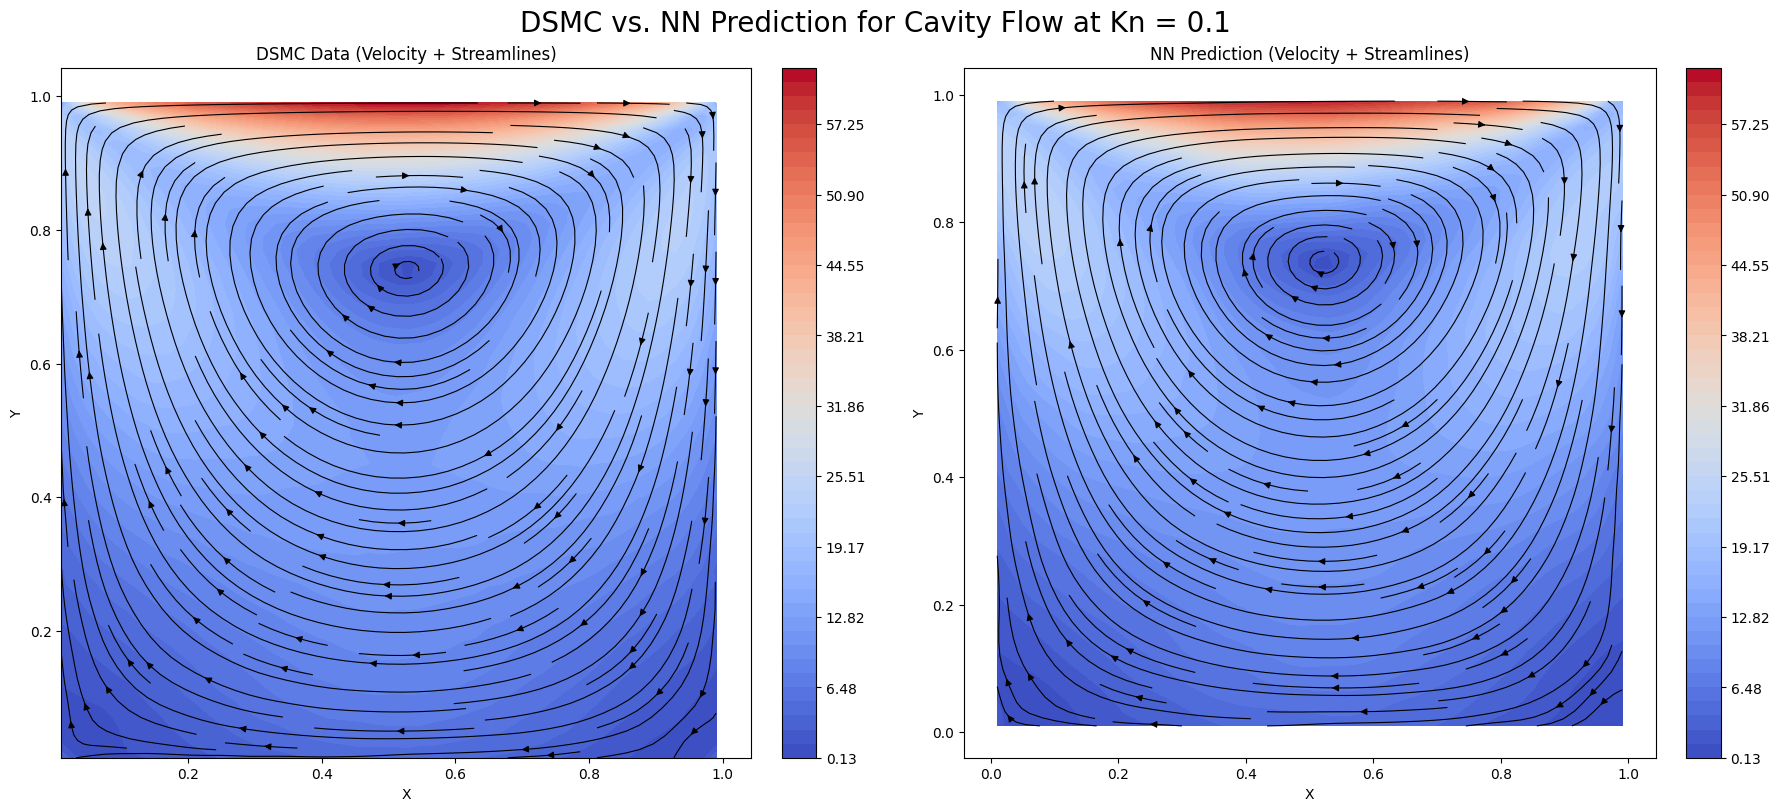

In [8]:
# --- گام ۰: وارد کردن کتابخانه‌ها و تنظیمات اولیه ---
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import griddata
import random

# برای اطمینان از نتایج تکرارپذیر
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# --- گام ۱: تابع پارسر نهایی برای خواندن فایل‌های Tecplot ---
def parse_tecplot_block_ascii(file_path):
    print(f"Parsing file: {file_path}...")
    try:
        with open(file_path, 'r') as f: content = f.read()
        var_block_match = re.search(r'VARIABLES\s*=\s*(.*?)ZONE', content, re.IGNORECASE | re.DOTALL)
        if not var_block_match: raise ValueError("Could not find VARIABLES block.")
        var_block_str = var_block_match.group(1)
        variables = re.findall(r'"(.*?)"', var_block_str)
        if not variables: raise ValueError("No variables found.")
        num_vars = len(variables)
        zone_header_match = re.search(r'ZONE.*?(I\s*=\s*(\d+)).*?(J\s*=\s*(\d+))', content, re.IGNORECASE | re.DOTALL)
        if not zone_header_match: raise ValueError("Could not find I, J dimensions.")
        i_dim, j_dim = int(zone_header_match.group(2)), int(zone_header_match.group(4))
        num_points = i_dim * j_dim
        metadata = {'I': i_dim, 'J': j_dim, 'variables': variables}
        dt_line_match = re.search(r'DT\s*=\s*\(.*\)', content, re.IGNORECASE)
        if not dt_line_match: raise ValueError("Could not find DT line.")
        data_start_index = dt_line_match.end()
        data_str = content[data_start_index:]
        flat_data = np.fromstring(data_str, sep=' ')
        expected_size = num_vars * num_points
        if flat_data.size < expected_size: raise ValueError(f"Data size mismatch: Expected {expected_size}, Found {flat_data.size}")
        flat_data = flat_data[:expected_size]
        block_data = flat_data.reshape((num_vars, num_points))
        df = pd.DataFrame(block_data.T, columns=variables)
        print(f"Successfully parsed {num_points} points and {num_vars} variables.")
        return df, metadata
    except Exception as e:
        print(f"An error occurred while parsing {file_path}: {e}")
        return pd.DataFrame(), {}

# --- گام ۲: بارگذاری و پیش‌پردازش داده برای یک فایل مشخص ---
DATA_DIR = './'
target_filename = 'CavityKn0.1.dat'
kn_value = 0.1

full_path = os.path.join(DATA_DIR, target_filename)
if not os.path.exists(full_path):
    raise FileNotFoundError(f"Target file not found at {full_path}. Please upload the file.")

df, metadata = parse_tecplot_block_ascii(full_path)
if df.empty: raise SystemExit("Data loading failed. Exiting.")

I, J = metadata['I'], metadata['J']
input_features, output_features = ['X', 'Y'], [v for v in metadata['variables'] if v not in ['X', 'Y']]
X, y = df[input_features].values, df[output_features].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)
print("\nData preprocessing for single Kn complete.")

# --- گام ۳: ساخت و آموزش مدل نهایی ---
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=2.0):
        super(FourierFeatures, self).__init__()
        self.output_dims, self.scale = output_dims, scale
        self.B = tf.random.normal([2, self.output_dims // 2], stddev=self.scale)
    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

L2_LAMBDA = 1e-6
FF_DIMS, DENSE_UNITS = 256, 256

pos_input = keras.Input(shape=(2,), name='position_input')
ff_layer = FourierFeatures(FF_DIMS)(pos_input)
x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(ff_layer)
x = layers.Dropout(0.2)(x)
x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
output_layer = layers.Dense(len(output_features), activation="sigmoid")(x)

model = keras.Model(inputs=pos_input, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mean_squared_error")
model.summary()

print("\nTraining the final high-capacity model for Kn =", kn_value)
history = model.fit(X_train_scaled, y_train_scaled, epochs=1000, batch_size=256, validation_data=(X_test_scaled, y_test_scaled),
                    callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True, verbose=1)])

# --- گام ۴: ارزیابی نهایی و مصورسازی ترکیبی ---
print("\nPredicting on the full domain for high-quality plotting...")
X_full_domain_scaled = scaler_X.transform(df[input_features].values)
y_pred_scaled = model.predict(X_full_domain_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_pred_df = pd.DataFrame(y_pred, columns=output_features)
y_pred_df['X'], y_pred_df['Y'] = df['X'].values, df['Y'].values

# --- تابع مصورسازی ترکیبی (کانتور و خطوط جریان) ---
def plot_overlayed_results(ground_truth_df, df_pred, I, J, kn_value):
    """
    Plots a 1x2 comparison, overlaying streamlines on velocity contours.
    Saves the final figure to a JPEG file.
    """

    # ایجاد یک شبکه برای رسم نمودار (1 سطر، 2 ستون)
    fig, axes = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True)
    fig.suptitle(f'DSMC vs. NN Prediction for Cavity Flow at Kn = {kn_value}', fontsize=20)

    # داده‌های مشترک
    X_grid = ground_truth_df['X'].values.reshape(J, I)
    Y_grid = ground_truth_df['Y'].values.reshape(J, I)

    # داده‌های سرعت
    Vmag_true = np.sqrt(ground_truth_df['U']**2 + ground_truth_df['V']**2).values.reshape(J, I)
    U_true_grid = ground_truth_df['U'].values.reshape(J, I)
    V_true_grid = ground_truth_df['V'].values.reshape(J, I)

    Vmag_pred = np.sqrt(df_pred['U']**2 + df_pred['V']**2).values.reshape(J, I)
    U_pred_grid = df_pred['U'].values.reshape(J, I)
    V_pred_grid = df_pred['V'].values.reshape(J, I)

    # پیدا کردن محدوده رنگ مشترک
    vmin = min(Vmag_true.min(), Vmag_pred.min())
    vmax = max(Vmag_true.max(), Vmag_pred.max())
    levels = np.linspace(vmin, vmax, 50)

    # --- نمودار سمت چپ: داده‌های واقعی DSMC ---
    ax1 = axes[0]
    ax1.set_title('DSMC Data (Velocity + Streamlines)')
    # 1. رسم کانتور سرعت
    cf = ax1.contourf(X_grid, Y_grid, Vmag_true, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax)
    fig.colorbar(cf, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
    # 2. رسم خطوط جریان روی همان نمودار
    ax1.streamplot(X_grid, Y_grid, U_true_grid, V_true_grid, density=1.5, color='black', linewidth=0.8)

    # --- نمودار سمت راست: پیش‌بینی شبکه عصبی ---
    ax2 = axes[1]
    ax2.set_title('NN Prediction (Velocity + Streamlines)')
    # 1. رسم کانتور سرعت
    cf2 = ax2.contourf(X_grid, Y_grid, Vmag_pred, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax)
    fig.colorbar(cf2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
    # 2. رسم خطوط جریان روی همان نمودار
    ax2.streamplot(X_grid, Y_grid, U_pred_grid, V_pred_grid, density=1.5, color='black', linewidth=0.8)

    # تنظیمات نهایی
    for ax in axes:
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    # ذخیره شکل
    output_filename = f'overlayed_results_kn_{kn_value}.jpg'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nنمودار ترکیبی در فایل '{output_filename}' ذخیره شد.")

    plt.show()

# فراخوانی تابع جدید برای رسم و ذخیره نمودار ترکیبی
plot_overlayed_results(df, y_pred_df, I, J, kn_value)

Parsing file: ./CavityKn0.1.dat...
Successfully parsed 2500 points and 11 variables.

Data preprocessing for single Kn complete.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ position_input (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fourier_features_4              │ (None, 256)            │             0 │
│ (FourierFeatures)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,689 (780.04 KB)

 Trainable params: 199,689 (780.04 KB)

 Non-trainable params: 0 (0.00 B)


Training the final high-capacity model for Kn = 0.1
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0539 - val_loss: 0.0130
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0121 - val_loss: 0.0065
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0071 - val_loss: 0.0042
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 12/1

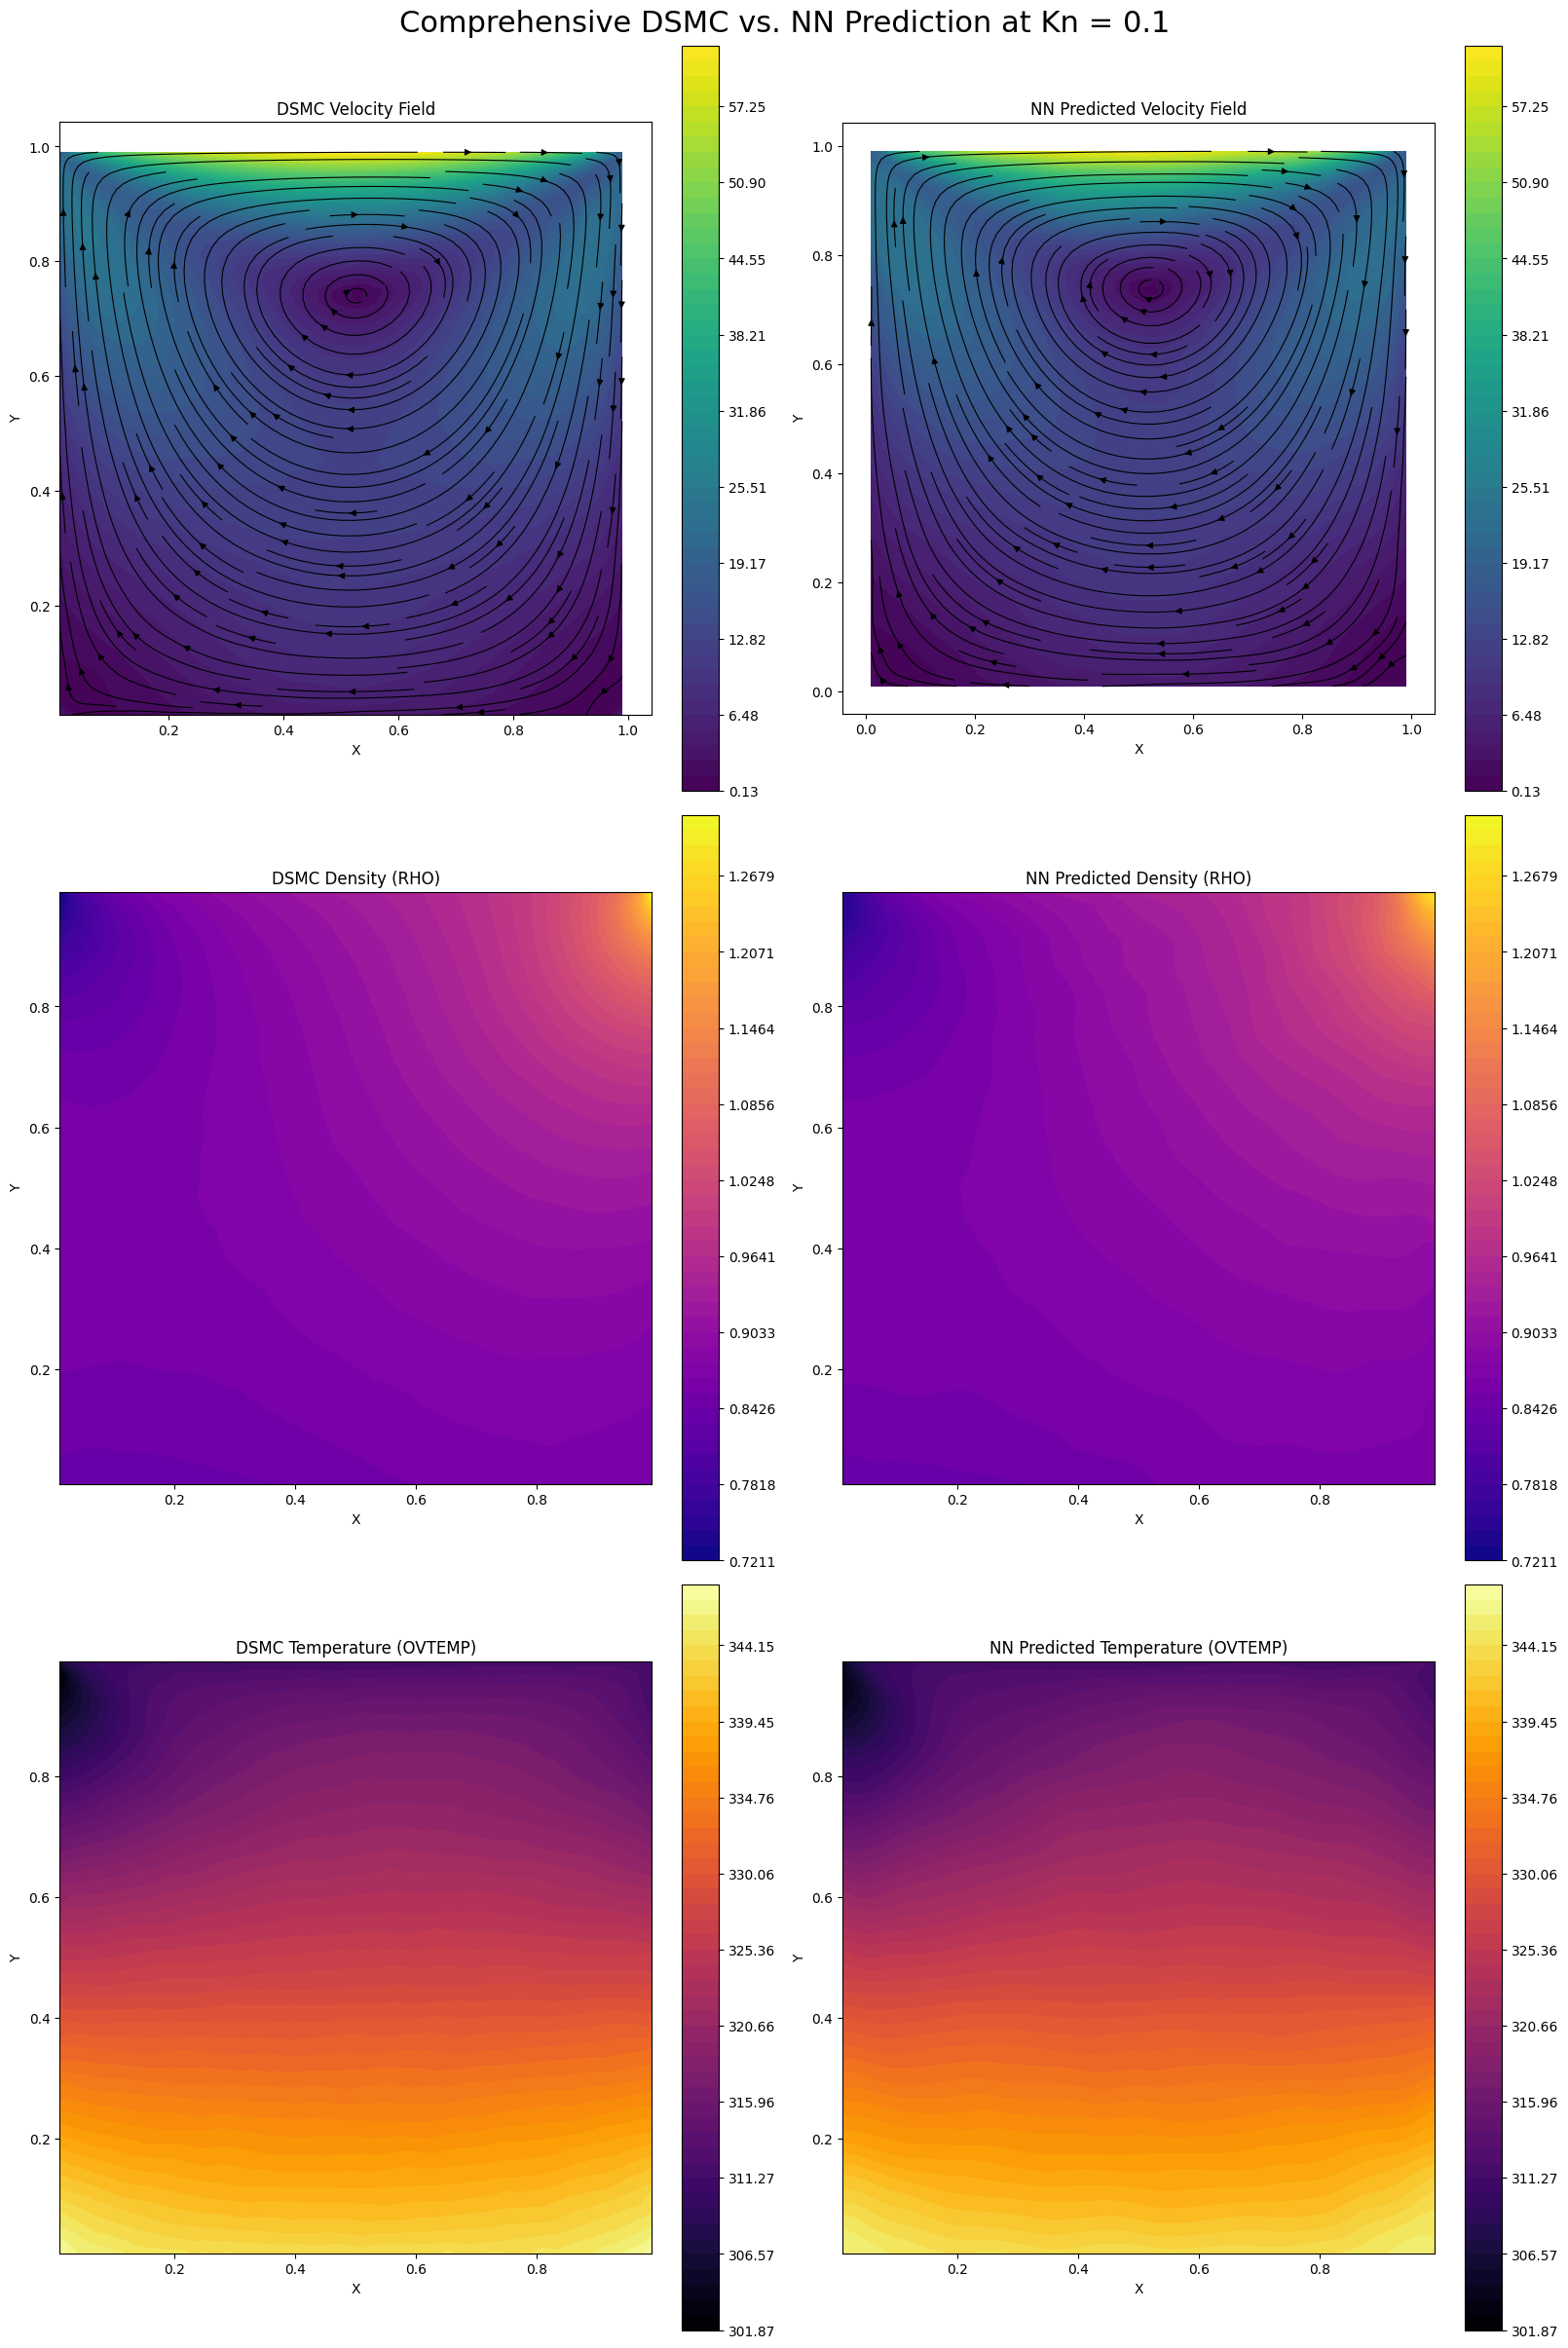

In [9]:
# --- گام ۰: وارد کردن کتابخانه‌ها و تنظیمات اولیه ---
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import griddata
import random

# برای اطمینان از نتایج تکرارپذیر
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# --- گام ۱: تابع پارسر نهایی برای خواندن فایل‌های Tecplot ---
def parse_tecplot_block_ascii(file_path):
    print(f"Parsing file: {file_path}...")
    try:
        with open(file_path, 'r') as f: content = f.read()
        var_block_match = re.search(r'VARIABLES\s*=\s*(.*?)ZONE', content, re.IGNORECASE | re.DOTALL)
        if not var_block_match: raise ValueError("Could not find VARIABLES block.")
        var_block_str = var_block_match.group(1)
        variables = re.findall(r'"(.*?)"', var_block_str)
        if not variables: raise ValueError("No variables found.")
        num_vars = len(variables)
        zone_header_match = re.search(r'ZONE.*?(I\s*=\s*(\d+)).*?(J\s*=\s*(\d+))', content, re.IGNORECASE | re.DOTALL)
        if not zone_header_match: raise ValueError("Could not find I, J dimensions.")
        i_dim, j_dim = int(zone_header_match.group(2)), int(zone_header_match.group(4))
        num_points = i_dim * j_dim
        metadata = {'I': i_dim, 'J': j_dim, 'variables': variables}
        dt_line_match = re.search(r'DT\s*=\s*\(.*\)', content, re.IGNORECASE)
        if not dt_line_match: raise ValueError("Could not find DT line.")
        data_start_index = dt_line_match.end()
        data_str = content[data_start_index:]
        flat_data = np.fromstring(data_str, sep=' ')
        expected_size = num_vars * num_points
        if flat_data.size < expected_size: raise ValueError(f"Data size mismatch: Expected {expected_size}, Found {flat_data.size}")
        flat_data = flat_data[:expected_size]
        block_data = flat_data.reshape((num_vars, num_points))
        df = pd.DataFrame(block_data.T, columns=variables)
        print(f"Successfully parsed {num_points} points and {num_vars} variables.")
        return df, metadata
    except Exception as e:
        print(f"An error occurred while parsing {file_path}: {e}")
        return pd.DataFrame(), {}

# --- گام ۲: بارگذاری و پیش‌پردازش داده برای یک فایل مشخص ---
DATA_DIR = './'
target_filename = 'CavityKn0.1.dat'
kn_value = 0.1

full_path = os.path.join(DATA_DIR, target_filename)
if not os.path.exists(full_path):
    raise FileNotFoundError(f"Target file not found at {full_path}. Please upload the file.")

df, metadata = parse_tecplot_block_ascii(full_path)
if df.empty: raise SystemExit("Data loading failed. Exiting.")

I, J = metadata['I'], metadata['J']
input_features, output_features = ['X', 'Y'], [v for v in metadata['variables'] if v not in ['X', 'Y']]
X, y = df[input_features].values, df[output_features].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)
print("\nData preprocessing for single Kn complete.")

# --- گام ۳: ساخت و آموزش مدل نهایی ---
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=2.0):
        super(FourierFeatures, self).__init__()
        self.output_dims, self.scale = output_dims, scale
        self.B = tf.random.normal([2, self.output_dims // 2], stddev=self.scale)
    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

L2_LAMBDA = 1e-6
FF_DIMS, DENSE_UNITS = 256, 256

pos_input = keras.Input(shape=(2,), name='position_input')
ff_layer = FourierFeatures(FF_DIMS)(pos_input)
x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(ff_layer)
x = layers.Dropout(0.2)(x)
x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
output_layer = layers.Dense(len(output_features), activation="sigmoid")(x)

model = keras.Model(inputs=pos_input, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mean_squared_error")
model.summary()

print("\nTraining the final high-capacity model for Kn =", kn_value)
history = model.fit(X_train_scaled, y_train_scaled, epochs=1000, batch_size=256, validation_data=(X_test_scaled, y_test_scaled),
                    callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True, verbose=1)])

# --- گام ۴: ارزیابی نهایی و مصورسازی جامع ---
print("\nPredicting on the full domain for high-quality plotting...")
X_full_domain_scaled = scaler_X.transform(df[input_features].values)
y_pred_scaled = model.predict(X_full_domain_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_pred_df = pd.DataFrame(y_pred, columns=output_features)
y_pred_df['X'], y_pred_df['Y'] = df['X'].values, df['Y'].values

# --- تابع مصورسازی جامع برای تمام پارامترها ---
def plot_full_field_comparison(ground_truth_df, df_pred, I, J, kn_value):
    """
    Plots a comprehensive 3x2 comparison for Velocity, Density, and Temperature.
    Saves the final figure to a JPEG file.
    """

    # ایجاد یک شبکه برای رسم نمودار (3 سطر، 2 ستون)
    fig, axes = plt.subplots(3, 2, figsize=(16, 24), constrained_layout=True)
    fig.suptitle(f'Comprehensive DSMC vs. NN Prediction at Kn = {kn_value}', fontsize=22)

    # داده‌های مشترک
    X_grid = ground_truth_df['X'].values.reshape(J, I)
    Y_grid = ground_truth_df['Y'].values.reshape(J, I)

    # --- 1. مصورسازی سرعت (Velocity) ---
    ax_v_true, ax_v_pred = axes[0, 0], axes[0, 1]
    Vmag_true = np.sqrt(ground_truth_df['U']**2 + ground_truth_df['V']**2).values.reshape(J, I)
    Vmag_pred = np.sqrt(df_pred['U']**2 + df_pred['V']**2).values.reshape(J, I)
    U_true_grid, V_true_grid = ground_truth_df['U'].values.reshape(J, I), ground_truth_df['V'].values.reshape(J, I)
    U_pred_grid, V_pred_grid = df_pred['U'].values.reshape(J, I), df_pred['V'].values.reshape(J, I)

    vmin, vmax = np.min([Vmag_true, Vmag_pred]), np.max([Vmag_true, Vmag_pred])
    levels = np.linspace(vmin, vmax, 50)

    ax_v_true.set_title('DSMC Velocity Field')
    cf1 = ax_v_true.contourf(X_grid, Y_grid, Vmag_true, levels=levels, cmap='viridis', vmin=vmin, vmax=vmax)
    ax_v_true.streamplot(X_grid, Y_grid, U_true_grid, V_true_grid, density=1.5, color='k', linewidth=0.8)
    fig.colorbar(cf1, ax=ax_v_true)

    ax_v_pred.set_title('NN Predicted Velocity Field')
    cf2 = ax_v_pred.contourf(X_grid, Y_grid, Vmag_pred, levels=levels, cmap='viridis', vmin=vmin, vmax=vmax)
    ax_v_pred.streamplot(X_grid, Y_grid, U_pred_grid, V_pred_grid, density=1.5, color='k', linewidth=0.8)
    fig.colorbar(cf2, ax=ax_v_pred)

    # --- 2. مصورسازی چگالی (Density - RHO) ---
    ax_r_true, ax_r_pred = axes[1, 0], axes[1, 1]
    Rho_true = ground_truth_df['RHO'].values.reshape(J, I)
    Rho_pred = df_pred['RHO'].values.reshape(J, I)
    vmin, vmax = np.min([Rho_true, Rho_pred]), np.max([Rho_true, Rho_pred])
    levels = np.linspace(vmin, vmax, 50)

    ax_r_true.set_title('DSMC Density (RHO)')
    cf3 = ax_r_true.contourf(X_grid, Y_grid, Rho_true, levels=levels, cmap='plasma', vmin=vmin, vmax=vmax)
    fig.colorbar(cf3, ax=ax_r_true)

    ax_r_pred.set_title('NN Predicted Density (RHO)')
    cf4 = ax_r_pred.contourf(X_grid, Y_grid, Rho_pred, levels=levels, cmap='plasma', vmin=vmin, vmax=vmax)
    fig.colorbar(cf4, ax=ax_r_pred)

    # --- 3. مصورسازی دما (Overall Temperature - OVTEMP) ---
    ax_t_true, ax_t_pred = axes[2, 0], axes[2, 1]
    Temp_true = ground_truth_df['OVTEMP'].values.reshape(J, I)
    Temp_pred = df_pred['OVTEMP'].values.reshape(J, I)
    vmin, vmax = np.min([Temp_true, Temp_pred]), np.max([Temp_true, Temp_pred])
    levels = np.linspace(vmin, vmax, 50)

    ax_t_true.set_title('DSMC Temperature (OVTEMP)')
    cf5 = ax_t_true.contourf(X_grid, Y_grid, Temp_true, levels=levels, cmap='inferno', vmin=vmin, vmax=vmax)
    fig.colorbar(cf5, ax=ax_t_true)

    ax_t_pred.set_title('NN Predicted Temperature (OVTEMP)')
    cf6 = ax_t_pred.contourf(X_grid, Y_grid, Temp_pred, levels=levels, cmap='inferno', vmin=vmin, vmax=vmax)
    fig.colorbar(cf6, ax=ax_t_pred)

    # تنظیمات نهایی
    for ax in axes.flat:
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    # ذخیره شکل
    output_filename = f'full_field_comparison_kn_{kn_value}.jpg'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nنمودار جامع در فایل '{output_filename}' ذخیره شد.")

    plt.show()

# فراخوانی تابع جدید برای رسم تمام نتایج
plot_full_field_comparison(df, y_pred_df, I, J, kn_value)

Parsing file: ./CavityKn0.1.dat...
Successfully parsed 2500 points and 11 variables.

Data preprocessing for single Kn complete.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ position_input (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fourier_features_5              │ (None, 256)            │             0 │
│ (FourierFeatures)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,689 (780.04 KB)

 Trainable params: 199,689 (780.04 KB)

 Non-trainable params: 0 (0.00 B)


Training the final high-capacity model for Kn = 0.1
Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0543 - val_loss: 0.0163
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0152 - val_loss: 0.0079
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0081 - val_loss: 0.0054
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0059 - val_loss: 0.0037
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 12/1

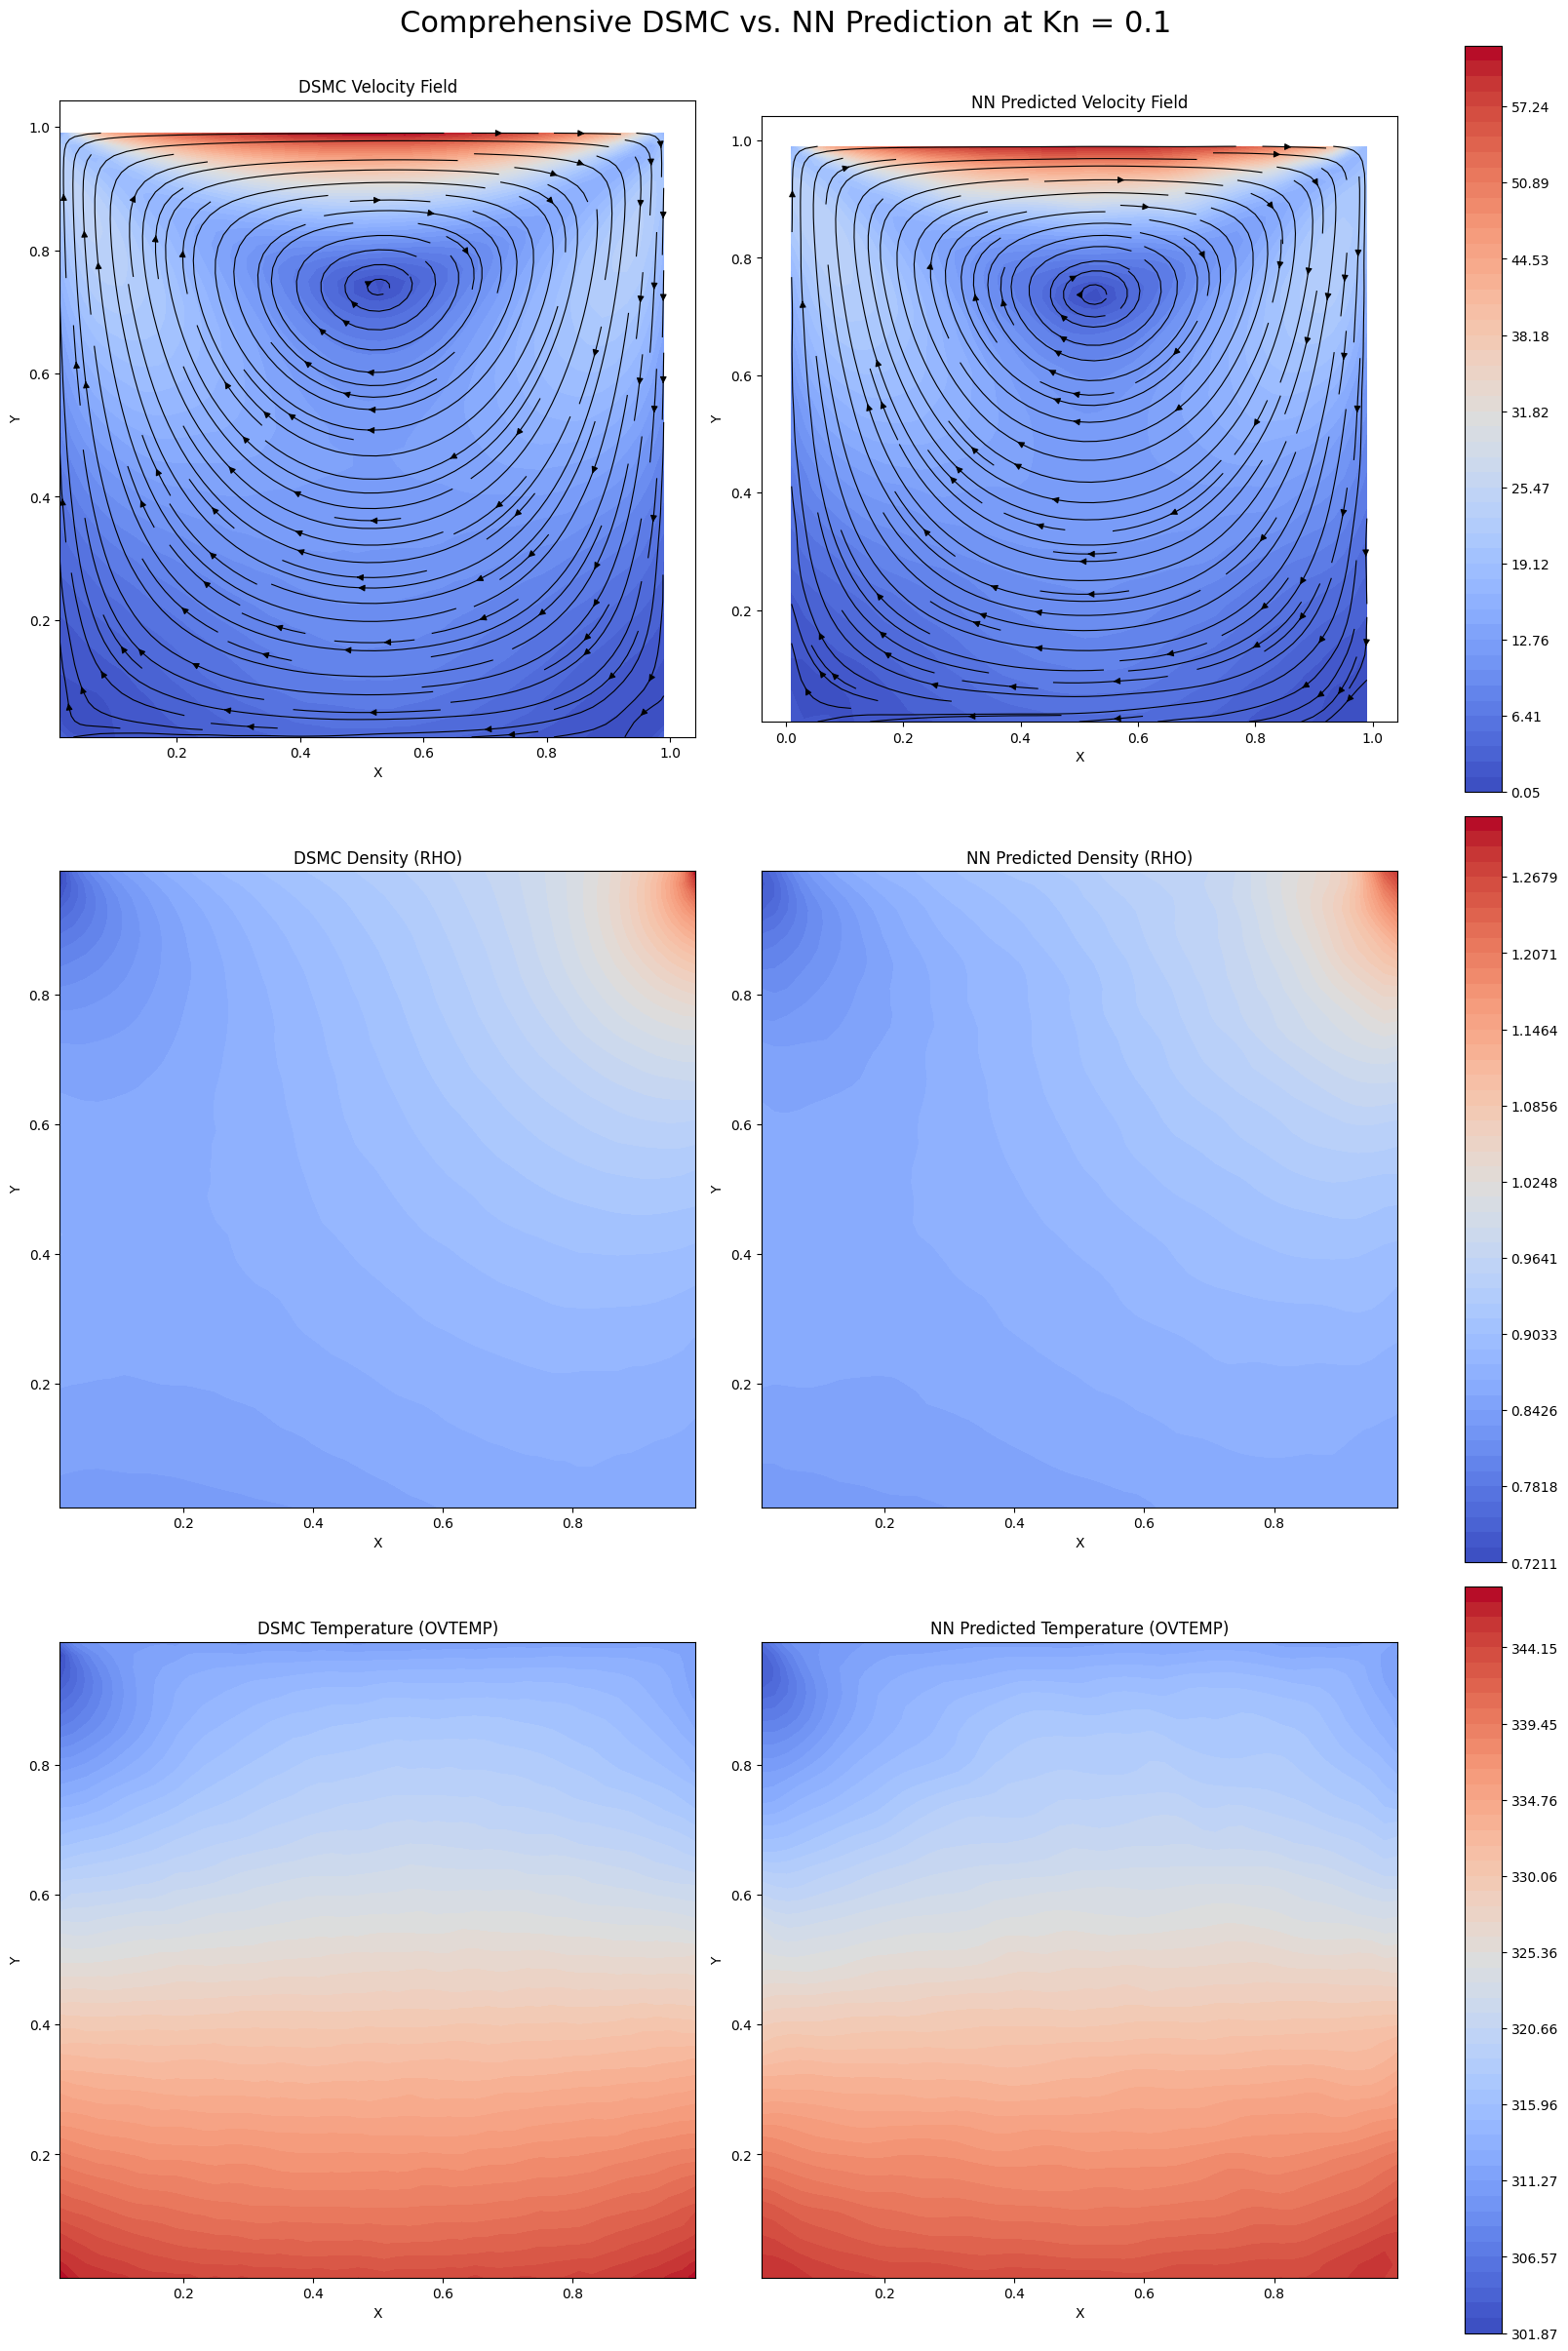

In [11]:
# --- گام ۰: وارد کردن کتابخانه‌ها و تنظیمات اولیه ---
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import griddata
import random

# برای اطمینان از نتایج تکرارپذیر
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# --- گام ۱: تابع پارسر نهایی برای خواندن فایل‌های Tecplot ---
def parse_tecplot_block_ascii(file_path):
    print(f"Parsing file: {file_path}...")
    try:
        with open(file_path, 'r') as f: content = f.read()
        var_block_match = re.search(r'VARIABLES\s*=\s*(.*?)ZONE', content, re.IGNORECASE | re.DOTALL)
        if not var_block_match: raise ValueError("Could not find VARIABLES block.")
        var_block_str = var_block_match.group(1)
        variables = re.findall(r'"(.*?)"', var_block_str)
        if not variables: raise ValueError("No variables found.")
        num_vars = len(variables)
        zone_header_match = re.search(r'ZONE.*?(I\s*=\s*(\d+)).*?(J\s*=\s*(\d+))', content, re.IGNORECASE | re.DOTALL)
        if not zone_header_match: raise ValueError("Could not find I, J dimensions.")
        i_dim, j_dim = int(zone_header_match.group(2)), int(zone_header_match.group(4))
        num_points = i_dim * j_dim
        metadata = {'I': i_dim, 'J': j_dim, 'variables': variables} # Corrected bug here
        dt_line_match = re.search(r'DT\s*=\s*\(.*\)', content, re.IGNORECASE)
        if not dt_line_match: raise ValueError("Could not find DT line.")
        data_start_index = dt_line_match.end()
        data_str = content[data_start_index:]
        flat_data = np.fromstring(data_str, sep=' ')
        expected_size = num_vars * num_points
        if flat_data.size < expected_size: raise ValueError(f"Data size mismatch: Expected {expected_size}, Found {flat_data.size}")
        flat_data = flat_data[:expected_size]
        block_data = flat_data.reshape((num_vars, num_points))
        df = pd.DataFrame(block_data.T, columns=variables)
        print(f"Successfully parsed {num_points} points and {num_vars} variables.")
        return df, metadata
    except Exception as e:
        print(f"An error occurred while parsing {file_path}: {e}")
        return pd.DataFrame(), {}

# --- گام ۲: بارگذاری و پیش‌پردازش داده برای یک فایل مشخص ---
DATA_DIR = './'
target_filename = 'CavityKn0.1.dat'
kn_value = 0.1

full_path = os.path.join(DATA_DIR, target_filename)
if not os.path.exists(full_path):
    raise FileNotFoundError(f"Target file not found at {full_path}. Please upload the file.")

df, metadata = parse_tecplot_block_ascii(full_path)
if df.empty: raise SystemExit("Data loading failed. Exiting.")

I, J = metadata['I'], metadata['J']
input_features = ['X', 'Y']
output_features = [v for v in metadata['variables'] if v not in ['X', 'Y']]
X = df[input_features].values
y = df[output_features].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)
print("\nData preprocessing for single Kn complete.")

# --- گام ۳: ساخت و آموزش مدل نهایی (با ظرفیت افزایش‌یافته) ---
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=2.5): # Tuned scale for smoothness
        super(FourierFeatures, self).__init__()
        self.output_dims, self.scale = output_dims, scale
        self.B = tf.random.normal([2, self.output_dims // 2], stddev=self.scale)
    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

L2_LAMBDA = 1e-6
FF_DIMS = 256
DENSE_UNITS = 256 # Increased capacity

pos_input = keras.Input(shape=(2,), name='position_input')
ff_layer = FourierFeatures(FF_DIMS)(pos_input)
x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(ff_layer)
x = layers.Dropout(0.2)(x)
x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
output_layer = layers.Dense(len(output_features), activation="sigmoid")(x)

model = keras.Model(inputs=pos_input, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mean_squared_error")
model.summary()

print(f"\nTraining the final high-capacity model for Kn = {kn_value}")
history = model.fit(X_train_scaled, y_train_scaled, epochs=1000, batch_size=256, validation_data=(X_test_scaled, y_test_scaled),
                    callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True, verbose=1)])

# --- گام ۴: ارزیابی نهایی و مصورسازی جامع ---
print("\nPredicting on the full domain for high-quality plotting...")
X_full_domain_scaled = scaler_X.transform(df[input_features].values)
y_pred_scaled = model.predict(X_full_domain_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_pred_df = pd.DataFrame(y_pred, columns=output_features)
y_pred_df['X'], y_pred_df['Y'] = df['X'].values, df['Y'].values

def plot_full_field_comparison(ground_truth_df, df_pred, I, J, kn_value):
    fig, axes = plt.subplots(3, 2, figsize=(16, 24), constrained_layout=True)
    fig.suptitle(f'Comprehensive DSMC vs. NN Prediction at Kn = {kn_value}', fontsize=22)

    X_grid = ground_truth_df['X'].values.reshape(J, I)
    Y_grid = ground_truth_df['Y'].values.reshape(J, I)

    # --- 1. Velocity Field ---
    Vmag_true = np.sqrt(ground_truth_df['U']**2 + ground_truth_df['V']**2).values.reshape(J, I)
    Vmag_pred = np.sqrt(df_pred['U']**2 + df_pred['V']**2).values.reshape(J, I)
    U_true_grid, V_true_grid = ground_truth_df['U'].values.reshape(J, I), ground_truth_df['V'].values.reshape(J, I)
    U_pred_grid, V_pred_grid = df_pred['U'].values.reshape(J, I), df_pred['V'].values.reshape(J, I)
    vmin, vmax = np.min([Vmag_true, Vmag_pred]), np.max([Vmag_true, Vmag_pred])
    levels = np.linspace(vmin, vmax, 50)

    axes[0, 0].set_title('DSMC Velocity Field')
    axes[0, 0].contourf(X_grid, Y_grid, Vmag_true, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0, 0].streamplot(X_grid, Y_grid, U_true_grid, V_true_grid, density=1.5, color='black', linewidth=0.8)

    axes[0, 1].set_title('NN Predicted Velocity Field')
    cf_v = axes[0, 1].contourf(X_grid, Y_grid, Vmag_pred, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0, 1].streamplot(X_grid, Y_grid, U_pred_grid, V_pred_grid, density=1.5, color='black', linewidth=0.8)
    fig.colorbar(cf_v, ax=axes[0, :].ravel().tolist())

    # --- 2. Density (RHO) ---
    Rho_true = ground_truth_df['RHO'].values.reshape(J, I)
    Rho_pred = df_pred['RHO'].values.reshape(J, I)
    vmin, vmax = np.min([Rho_true, Rho_pred]), np.max([Rho_true, Rho_pred])
    levels = np.linspace(vmin, vmax, 50)

    axes[1, 0].set_title('DSMC Density (RHO)')
    axes[1, 0].contourf(X_grid, Y_grid, Rho_true, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax)

    axes[1, 1].set_title('NN Predicted Density (RHO)')
    cf_r = axes[1, 1].contourf(X_grid, Y_grid, Rho_pred, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax)
    fig.colorbar(cf_r, ax=axes[1, :].ravel().tolist())

    # --- 3. Temperature (OVTEMP) ---
    Temp_true = ground_truth_df['OVTEMP'].values.reshape(J, I)
    Temp_pred = df_pred['OVTEMP'].values.reshape(J, I)
    vmin, vmax = np.min([Temp_true, Temp_pred]), np.max([Temp_true, Temp_pred])
    levels = np.linspace(vmin, vmax, 50)

    axes[2, 0].set_title('DSMC Temperature (OVTEMP)')
    axes[2, 0].contourf(X_grid, Y_grid, Temp_true, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax)

    axes[2, 1].set_title('NN Predicted Temperature (OVTEMP)')
    cf_t = axes[2, 1].contourf(X_grid, Y_grid, Temp_pred, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax)
    fig.colorbar(cf_t, ax=axes[2, :].ravel().tolist())

    for ax in axes.flat:
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    output_filename = f'final_full_comparison_kn_{kn_value}.jpg'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nنمودار جامع در فایل '{output_filename}' ذخیره شد.")

    plt.show()

# فراخوانی تابع نهایی
plot_full_field_comparison(df, y_pred_df, I, J, kn_value)